<a href="https://colab.research.google.com/github/031wnstjd/Deep-Learning/blob/master/DL_11_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL_11 - CAM

In [ ]:
name = input("Name :")
ID = input("student ID :")

Name :추준성
student ID :2016145028


## Object Localization

### Prepare

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

In [ ]:
ls

sample_data/


####Dataset(CUB)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45" -nc -O dataset/CUB_200_2011.tgz && rm -rf /tmp/cookies.txt
!wget -nc -O dataset/CUBV2.tar "https://onedrive.live.com/download?cid=B7111B95B80CCC66&resid=B7111B95B80CCC66%2130812&authkey=AFMzb4akufUiWU0"

In [ ]:
!mkdir -p dataset/CUB_200_2011
!tar xvf dataset/CUB_200_2011.tgz -C dataset/
!mv dataset/CUB_200_2011/images dataset/train && rm -rf dataset/CUB_200_2011

!mkdir -p dataset/test
!tar xvf dataset/CUBV2.tar -C dataset/test

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(), #이미지를 tensor자료형으로 변한
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 정규화

batch_size = 64

trainset = torchvision.datasets.ImageFolder(root='./dataset/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='./dataset/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
trainset

Dataset ImageFolder
    Number of datapoints: 11788
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### VGG16 구현

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            #3 224 224
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #64 112 112
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #128 56 56
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #256 28 28
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #512 14 14
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.avgpool = nn.AvgPool2d((7,7)) #512 7 7

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):

        #print(x.size())
        features = self.features(x)
        x = self.avgpool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        
        return x

### VGG16 CAM 구현

#### Network

In [ ]:
class VGG16_CAM(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_CAM, self).__init__()
        self.features = nn.Sequential(
            #3 224 224
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #64 112 112
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #128 56 56
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #256 28 28
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #512 14 14
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )


####################################################################

        self.conv = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.relu = nn.ReLU(True)
        self.avgpool = nn.AdaptiveAvgPool2d(1) # 1024 1 1
        self.classifier = nn.Linear(1024, num_classes)


    def forward(self, x, labels=None, return_cam=False):

        x = self.features(x)
        x = self.conv(x)
        x = self.relu(x)
        logits = self.avgpool(x)
        logits = logits.view(logits.size(0), -1)
        logits = self.classifier(logits)

        if return_cam:
            feature_map = x.detach().clone()
            # self.classifier.weight.shape = [classxchannel] -> [200,1024]
            cam_weights = self.classifier.weight[labels] 
            cams = (cam_weights.view(*feature_map.shape[:2], 1, 1) *
                    feature_map).mean(1, keepdim=False)
            return cams
        
        return logits

####################################################################

####Trainer

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

class trainer:
  def __init__(self, model, train_loader, opt, epoch_size=10, learning_rate=1e-2, use_cuda=True ):
    self.use_cuda = use_cuda #gpu 사용 여부
    if use_cuda :
      self.net = model.cuda() # gpu연산을 위한 model to gpu
    else :
      self.net = model
    self.train_loader = train_loader 
    self.opt = opt # optmizer 종류 설정을 위한 인자
    self.epoch_size = epoch_size # epoch
    self.learning_rate = learning_rate 
    self.validation_epoch = 2 # validation 빈도
    self.criterion = nn.CrossEntropyLoss() # loss


  def train(self, valdiation_loader=None):
  
    #Optimizer
    if self.opt == "SGD":
      optimizer = optim.SGD(self.net.parameters(), lr=self.learning_rate) 
    elif self.opt == "Adam":
      optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate) 
    elif self.opt == "Adagrad":
      optimizer = optim.Adagrad(self.net.parameters(), lr=self.learning_rate) 

    max_test_acc = 0
    for epoch in tqdm(range(self.epoch_size)):
      self.net.train() # weight&bias를 update할 수 있는 상태로 변환

      for i, (inputs, targets) in enumerate(self.train_loader): 
        if self.use_cuda: #gpu연산
          inputs = inputs.cuda() 
          targets = targets.cuda()

        # gradient를 0으로 초기화
        optimizer.zero_grad()
        
        outputs = self.net(inputs) #forward 
        loss = self.criterion(outputs, targets) #loss계산
        loss.backward() #backward -> gradient계산
        optimizer.step() #최적화 -> weight&bias update


      if (epoch+1)%self.validation_epoch == 0:
        train_acc = self.validate(self.train_loader)
        line = 'Train Acc | Epoch {:d}/{:d} | ACC {:f}'.format((epoch+1), self.epoch_size, train_acc)
        print(line)

        if valdiation_loader != None :
          val_acc = self.validate(valdiation_loader)
          line_val = 'Test Acc | Epoch {:d}/{:d} | ACC {:f}'.format((epoch+1), self.epoch_size, val_acc)
          print(line_val)
        
        print("============================================")

  @torch.no_grad()
  def validate(self, data_loader):
    self.net.eval()
    for i, (inputs, targets) in enumerate(data_loader): 
      if self.use_cuda: #gpu연산
        inputs = inputs.cuda() 
        targets = targets.cuda()

      pred = self.net(inputs) #forward
      pred = torch.argmax(pred, dim = 1) #accuracy 측정
      pred_c = pred
      target_c = targets

      if i == 0:
        acc = (pred_c==target_c)
      else : 
        acc = torch.cat([acc, (pred_c==target_c)], axis=0)
        
    acc = acc.float().mean() * 100

    return acc.item()

####Training & Validation

ImageNet pretrained VGG16 weight load

In [ ]:
from torch.utils.model_zoo import load_url
model_urls = {
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth'
}




In [ ]:
state_dict = load_url(model_urls['vgg16'], progress=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

dictionary의 특정 key와 해당 value를 제거하는 함수

In [ ]:
def remove_layer(state_dict, keyword):
    keys = [key for key in state_dict.keys()]
    for key in keys:
        if keyword in key:
            state_dict.pop(key)
    return state_dict

ImageNet pretrained VGG16 weight에서 classifer에 해당하는 weight를 제거

In [ ]:
state_dict = remove_layer(state_dict, 'classifier.')

In [ ]:
state_dict.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias'])

CAM을 위한 VGG16 모델 객체 선언

In [ ]:
net = VGG16_CAM(num_classes=200).cuda()
net

VGG16_CAM(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

feature extractor network를 ImageNet pretrained weight로 initialization

In [ ]:
net.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['conv.weight', 'conv.bias', 'classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [ ]:
trainer_CAM = trainer(net, trainloader, "SGD", epoch_size=1, learning_rate=1e-3)
trainer_CAM.train()
trainer_CAM.validate(testloader)

100%|██████████| 1/1 [05:27<00:00, 327.93s/it]


1.0000001192092896

### CAM Visualization

torch.Size([7, 7])


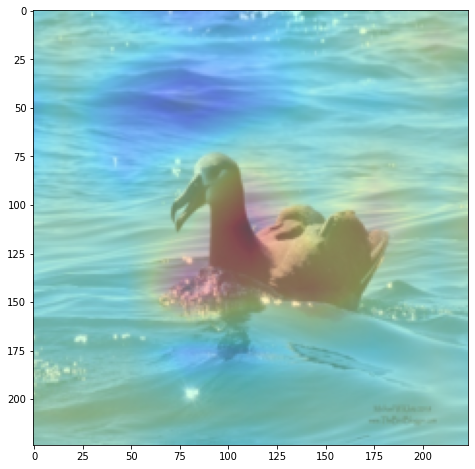

In [ ]:
from matplotlib import pyplot as plt
import skimage.transform as tf

def imshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)), alpha=0.5)

net.eval() # evaluation 상태로 변환
for j, (test_data, test_target) in enumerate(testloader):
    test_data = test_data.cuda() #gpu연산 
    test_target = test_target.cuda() #gpu연산
    cam = net(test_data, test_target, return_cam=True)[0] #forward

    if j == 0:
        break
print(cam.shape)
cam = cam.detach().cpu().numpy().astype(np.float)
cam -= np.min(cam)
cam /= np.max(cam)
test_data = test_data[0].cpu()

plt.figure(figsize=(8,8))
cam = tf.resize(cam, [224,224])
plt.imshow(cam, cmap='jet', alpha=0.5)
imshow(test_data)
plt.show()

#### VGG16 Regression Network

In [ ]:
class VGG16_REG(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_REG, self).__init__()
        self.features = nn.Sequential(
            #3 224 224
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #64 112 112
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #128 56 56
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #256 28 28
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            #512 14 14
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.avgpool = nn.AvgPool2d((7,7)) #512 7 7

####################################################################

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        self.localizer = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4),
        )

    def forward(self, x):

        features = self.feature(x)
        x = self.avgpool(features)
        x = x.view(features.size(0), -1)
        x_cls = self.classifier(x)
        x_loc = self.localizer(x)
        
        return x_cls, x_loc

####################################################################